# Introduction

This project is an introduction to deep learning for image classification using [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) and the [Sequential API](https://keras.io/guides/sequential_model/). In it, I build and optimize a multi-layer perceptron feed-forward neural network to classify images from the [KMINST](http://codh.rois.ac.jp/kmnist/index.html.en) dataset. Then, I implement a convolutional neural network and optimize its layers and parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

from IPython.display import display, Markdown

from os import cpu_count

plt.style.use('seaborn-dark')

# Download, Load, Visualize, and Reshape the Data

In [2]:
X_train = np.load('data/kmnist-train-imgs.npz')['arr_0']
y_train = np.load('data/kmnist-train-labels.npz')['arr_0']
X_test = np.load('data/kmnist-test-imgs.npz')['arr_0']
y_test = np.load('data/kmnist-test-labels.npz')['arr_0']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Just like the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) dataset, we have 60,000 images in the training set and 10,000 images in the test set. Each image is 28x28 pixels.

In [3]:
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0 118 255 255 124   1   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  36 238 255 146   2   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  12 203 255 220  14   0   0   0  11
  132  95 187  95   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 149 255 251  66   0   0   0   7 168
  136  10 223 245  67   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  51 247 255 156   1   0   0   0 130 201
    9   0 158 255 170   0   0   0   0   0]
 [  0   0   0   0   0   0   0  11 212 255 226  22   0   0   0  79 240  38
    0   0 143 255 197   0   0   0   0   0]
 [  0   0   0   0   0   0   0 148 255 255 107   0   0   0  33 237 121   0
    0   0 144 255 222   0   0   0   0   0]
 [  0   0   0   0   0   0   0 205 255 178   3   0   0   1 179 208   5   0
    0   0 126 255 166   0   0   0   0   0]
 [  0   0   0   0   0   0   7 245 255  76   0   0   0 124 254 10

Again, just as in the MNIST dataset, the images are grayscale with a value of 0-255 indicating the darkness of the pixel.

In [4]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Text(0, 0.5, 'Count')

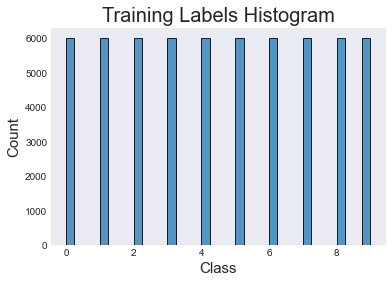

In [5]:
sns.histplot(y_train)
plt.title('Training Labels Histogram', fontsize=20)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Count', fontsize=15)

Our labels are 0-9 and we have a very balanced training set.

## Samples of each class
Let's look at several samples of each class.

In [6]:
samples = 10
label_sample_indexes = dict()
for label in set(y_train):
    label_sample_indexes[label] = [i for i,x in enumerate(y_train) if x==label][0:samples]
label_sample_indexes

{0: [2, 12, 29, 37, 38, 49, 76, 88, 93, 100],
 1: [3, 8, 9, 11, 16, 32, 46, 51, 52, 53],
 2: [5, 26, 55, 56, 74, 79, 90, 91, 105, 122],
 3: [21, 54, 59, 69, 73, 80, 98, 107, 112, 146],
 4: [4, 6, 58, 62, 77, 109, 113, 116, 121, 147],
 5: [10, 13, 19, 23, 33, 35, 50, 60, 61, 85],
 6: [15, 24, 25, 28, 31, 41, 48, 57, 63, 64],
 7: [1, 14, 17, 20, 22, 27, 42, 43, 44, 66],
 8: [0, 7, 36, 39, 40, 45, 67, 68, 78, 92],
 9: [18, 30, 34, 47, 71, 72, 82, 83, 101, 103]}

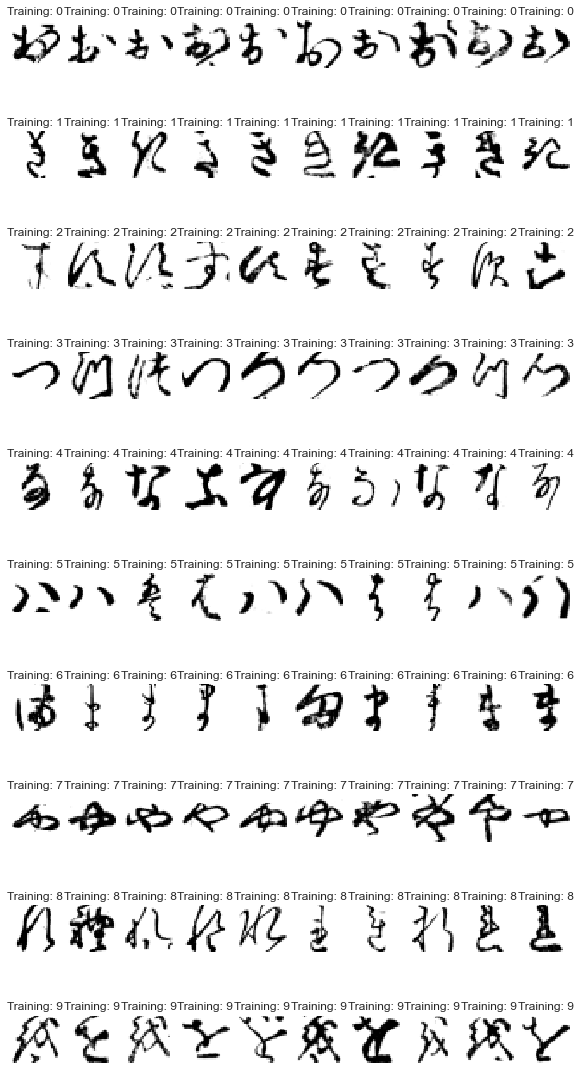

In [7]:
labels = label_sample_indexes.keys()
_, axes = plt.subplots(nrows=len(labels), ncols=samples, figsize=(10, 20))
for ax_row, label in zip(axes, labels):
    for ax, image in zip(ax_row, X_train[label_sample_indexes[label]]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f"Training: {label}")

## Reshaping the Data

Here I will flatten the image itself into a 1D array.

In [8]:
train_shape = X_train.shape
X_train_flattened = X_train.reshape(train_shape[0], train_shape[1] * train_shape[2])
test_shape = X_test.shape
X_test_flattened = X_test.reshape(test_shape[0], test_shape[1] * test_shape[2])

print(X_train_flattened.shape, X_test_flattened.shape)

(60000, 784) (10000, 784)


In [9]:
scaler = StandardScaler(with_mean=False, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)
print("Average:", np.mean(X_train_scaled[:, 350]))
print("Std dev:", np.std(X_train_scaled[:, 350]))

Average: 0.800933357655329
Std dev: 0.9999999999997488


# Classification with Logistic Regression

As in the example, first I'll perform a logistic regression classification to compare, later, with the deep learning models.

In [10]:
sgd = SGDClassifier(loss="log", n_jobs=cpu_count())
sgd.fit(X_train_scaled, y_train)

y_predicted = sgd.predict(X_test_scaled)

acc = 100. * accuracy_score(y_test, y_predicted)
cm = confusion_matrix(y_test, y_predicted)

print(f"Accuracy: {acc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 65.45
Confusion Matrix:
[[666   7  10  49  39  90  10  30  45  54]
 [  2 660  59  19  24  19  76  13  30  98]
 [  5  41 583  34  29  25  96  16  52 119]
 [  2  43  47 751  10  34  37  20  18  38]
 [ 57  59  43  35 564  15  49  25  27 126]
 [ 12  43  58  17  17 684  50   6  57  56]
 [  6  30  93  15  18  13 744  32   7  42]
 [ 20  38  22  25  86  32  77 510  79 111]
 [  4  62  57  55   5  29  60  11 654  63]
 [ 11  63  51   8  47  23  25  12  31 729]]


The logistic regression performed with an accuracy of about 65%.

# Classification with Multi-Layer Perceptron

For this multiclass classification problem I will choose the [sparse_categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) for the probabilistic loss function since we have a multiclass problem and our classes are represented as integers (i.e., not one-hot encoded). I'll also begin with the [SGD](https://keras.io/api/optimizers/sgd/) optimizer as I have worked with this the most in class so far.




In [11]:
def build_model(n_hidden=2, n_neurons=8, dropout=None, loss='sparse_categorical_crossentropy', optimizer=SGD()):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Rescaling(scale=1./255))
    model.add(Flatten())
    for hidden_layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        if dropout:
            model.add(Dropout(dropout))
    model.add(Dense(len(labels), activation='softmax'))
    model.summary()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


In [12]:
def fit_and_predict(model, batch_size=256, epochs=10):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    acc = 100. * accuracy_score(y_test, predicted_classes)
    cm = confusion_matrix(y_test, predicted_classes)

    return acc, cm

In [13]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,442
Trainable params: 6,442
Non-trainable params: 0
_________________________________________________________________


In [14]:
acc, cm = fit_and_predict(model)

Epoch 1/10
235/235 [==============================] - 0s 771us/step - loss: 2.1218 - accuracy: 0.2137
Epoch 2/10
235/235 [==============================] - 0s 767us/step - loss: 1.7675 - accuracy: 0.4309
Epoch 3/10
235/235 [==============================] - 0s 760us/step - loss: 1.5186 - accuracy: 0.5258
Epoch 4/10
235/235 [==============================] - 0s 784us/step - loss: 1.3664 - accuracy: 0.5683
Epoch 5/10
235/235 [==============================] - 0s 771us/step - loss: 1.2622 - accuracy: 0.5939
Epoch 6/10
235/235 [==============================] - 0s 754us/step - loss: 1.1788 - accuracy: 0.6146
Epoch 7/10
235/235 [==============================] - 0s 754us/step - loss: 1.1091 - accuracy: 0.6324
Epoch 8/10
235/235 [==============================] - 0s 754us/step - loss: 1.0506 - accuracy: 0.6509
Epoch 9/10
235/235 [==============================] - 0s 754us/step - loss: 1.0004 - accuracy: 0.6735
Epoch 10/10
235/235 [==============================] - 0s 754us/step - loss: 0.956

In [15]:
print(f"Accuracy: {acc:.2f}%")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 54.26%
Confusion Matrix:
[[737   1   1  10  76  59   1  50  35  30]
 [  7 538 125  10  22   0  98   8 134  58]
 [  2 135 357  36  54   4 148  69 143  52]
 [ 10  80  24 662  19  24  15  12 152   2]
 [ 68  37  94  26 596  10  60  42  30  37]
 [  7  64  76  16  31 252 262   1 267  24]
 [  2  50 131   5  95   1 654  26  32   4]
 [ 14  88 108  11 163   0  12 475  16 113]
 [ 15 155  31  65  39  63  38   8 561  25]
 [ 30  93 117   2  86   1  14  48  15 594]]


## Optimize the Model

In [ ]:
build_model_params = {
    'n_hidden': [0, 1, 2],
    'n_neurons': [32, 128, 512],
    'dropout': [.1, .2],
    'optimizer': [SGD(), RMSprop(), Adam()]
}
fit_and_predict_params = {
    'epochs': [25, 50]
}

keys, values = zip(*build_model_params.items())
build_model_kwargses = [dict(zip(keys, v)) for v in itertools.product(*values)]
keys, values = zip(*fit_and_predict_params.items())
fit_and_predict_kwargses = [dict(zip(keys, v)) for v in itertools.product(*values)]

results = []
for build_model_kwargs in build_model_kwargses:
    for fit_and_predict_kwargs in fit_and_predict_kwargses:
        model = build_model(**build_model_kwargs)
        acc, cm = fit_and_predict(model, **fit_and_predict_kwargs)
        results.append((build_model_kwargs, fit_and_predict_kwargs, acc, cm))


In [17]:
best_acc = 0
md =  "|accuracy|n_hidden|n_neurons|dropout|optimizer|epochs|\n"
md += "|--------|--------|---------|-------|---------|------|\n"
for result in results:
    acc = result[2]
    if acc > best_acc:
        best_acc = acc
        best_build_model_params = result[0]
        best_fit_and_predict_params = result[1]
        best_cm = result[3]
    md += f"|{acc:.2f}%|{result[0]['n_hidden']}|{result[0]['n_neurons']}|{result[0]['dropout']}|{type(result[0]['optimizer'])}|{result[1]['epochs']}|\n"
display(Markdown(md))

|accuracy|n_hidden|n_neurons|dropout|optimizer|epochs|
|--------|--------|---------|-------|---------|------|
|66.96%|0|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.59%|0|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|70.34%|0|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|70.19%|0|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|70.24%|0|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|70.02%|0|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|66.69%|0|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.66%|0|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|70.28%|0|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|70.24%|0|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|69.98%|0|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|69.86%|0|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|66.72%|0|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.63%|0|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|70.37%|0|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|69.97%|0|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|70.24%|0|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|69.88%|0|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|67.27%|0|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.38%|0|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|70.60%|0|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|69.95%|0|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|70.10%|0|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|70.04%|0|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|66.71%|0|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.56%|0|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|70.28%|0|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|69.93%|0|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|70.04%|0|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|70.30%|0|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|66.69%|0|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|68.38%|0|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|69.75%|0|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|69.92%|0|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|69.95%|0|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|70.19%|0|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|73.31%|1|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|76.27%|1|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|82.59%|1|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|83.50%|1|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|82.25%|1|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|82.98%|1|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|72.61%|1|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|75.90%|1|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|80.67%|1|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|81.06%|1|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|79.68%|1|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|80.96%|1|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|76.77%|1|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|80.97%|1|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|89.65%|1|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|89.63%|1|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|89.34%|1|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|89.25%|1|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|76.38%|1|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|79.96%|1|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|89.04%|1|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|89.59%|1|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|89.50%|1|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|88.84%|1|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|76.90%|1|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|81.96%|1|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|91.45%|1|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|92.39%|1|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|92.10%|1|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|92.33%|1|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|77.37%|1|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|81.61%|1|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|92.10%|1|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|91.68%|1|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|91.42%|1|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|92.03%|1|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|74.63%|2|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|78.34%|2|32|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|82.82%|2|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|83.22%|2|32|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|82.68%|2|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|82.54%|2|32|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|72.18%|2|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|76.83%|2|32|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|80.75%|2|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|80.94%|2|32|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|78.73%|2|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|79.85%|2|32|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|78.05%|2|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|82.95%|2|128|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|90.51%|2|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|90.24%|2|128|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|91.11%|2|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|90.34%|2|128|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|76.60%|2|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|82.14%|2|128|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|89.93%|2|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|89.96%|2|128|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|89.37%|2|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|89.50%|2|128|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|
|79.84%|2|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|85.30%|2|512|0.1|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|91.40%|2|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|92.58%|2|512|0.1|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|92.10%|2|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|25|
|92.32%|2|512|0.1|<class 'keras.optimizer_v2.adam.Adam'>|50|
|79.77%|2|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|25|
|84.51%|2|512|0.2|<class 'keras.optimizer_v2.gradient_descent.SGD'>|50|
|92.15%|2|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|25|
|92.83%|2|512|0.2|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|50|
|92.53%|2|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|25|
|91.68%|2|512|0.2|<class 'keras.optimizer_v2.adam.Adam'>|50|


In [18]:
print(f"\nBest accuracy: {best_acc:.2f}% - {best_build_model_params} {best_fit_and_predict_params}\n")
print("Best Confusion Matrix:")
print(best_cm)


Best accuracy: 92.83% - {'n_hidden': 2, 'n_neurons': 512, 'dropout': 0.2, 'optimizer': <keras.optimizer_v2.rmsprop.RMSprop object at 0x000001CC624D9C90>} {'epochs': 50}

Best Confusion Matrix:
[[946   1   2   0  14  11   2  17   7   0]
 [  1 894  15   1  13   7  34  11  12  12]
 [ 11   5 876  54   6  13   6  11   9   9]
 [  1   1  14 964   3   7   1   4   2   3]
 [ 19  16   4   9 901   6  10  13  18   4]
 [  2   7  17   7   1 943  14   3   2   4]
 [  5   7  18   5  11   0 945   4   3   2]
 [  5   3   7   1   1   4   9 956   4  10]
 [ 11  18   5  21   3   8   5   2 924   3]
 [ 11   4  14   6   8   2   8   6   7 934]]


More hidden layers, more neurons per layer, and the [Adam]() optimizer performed the best. Accuracy is now nearly 93%.

# Implementing a Convolutional Neural Network

For this, I will begin with my best parameters from the multi-layer perceptron model: 2 hidden Dense layers, 512 neurons per dense layer, with a .2 dropout and the [Adam](https://keras.io/api/optimizers/adam/) optimizer.

In [19]:
def build_cnn_model(
    n_filters=[32, 64], kernel_size=(3, 3), n_hidden=2, pooling=MaxPooling2D(pool_size=(2, 2)),
    n_neurons=512, dropout=.2, loss='sparse_categorical_crossentropy', optimizer=Adam()):
    
    model = Sequential()

    model.add(Input(shape=(28, 28, 1)))
    model.add(Rescaling(scale=1./255))
    
    for filters in n_filters:
        model.add(Conv2D(filters=filters, kernel_size=kernel_size))

    if pooling:
        model.add(pooling)
    
    if pooling is None or type(pooling) is MaxPooling2D:
        model.add(Flatten())

    for hidden_layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        if dropout:
            model.add(Dropout(dropout))
    model.add(Dense(len(labels), activation='softmax'))
    model.summary()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [20]:
model = build_cnn_model()

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_109 (Rescaling)   (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten_109 (Flatten)       (None, 9216)              0         
                                                                 
 dense_219 (Dense)           (None, 512)               4719104   
                                                    

In [21]:
acc, cm = fit_and_predict(model, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 34s 72ms/step - loss: 0.2584 - accuracy: 0.9200
Epoch 2/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0780 - accuracy: 0.9759
Epoch 3/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0470 - accuracy: 0.9845
Epoch 4/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0334 - accuracy: 0.9891
Epoch 5/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0264 - accuracy: 0.9914
Epoch 6/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0274 - accuracy: 0.9913
Epoch 7/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0224 - accuracy: 0.9931
Epoch 8/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0185 - accuracy: 0.9940
Epoch 9/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0172 - accuracy: 0.9946
Epoch 10/10
469/469 [==============================] - 34s 72ms/step - loss: 0.018

In [22]:
print(f"Accuracy: {acc:.2f}%")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 93.80%
Confusion Matrix:
[[947   0   3   1  23   5   1   9   7   4]
 [  1 917  13   2  17   2  19   2   9  18]
 [  6   3 867  83  11   6   8   2   8   6]
 [  0   0   5 989   1   3   1   1   0   0]
 [ 11   3   2  12 935   2   6   2  25   2]
 [  1   2  25  19   4 929  10   0   5   5]
 [  4   0  15   6   9   3 959   1   2   1]
 [  7   3   5   5   5   1  23 909  21  21]
 [  1   5   1  10   2   3   4   1 972   1]
 [  9   1   1   3   8   1   9   3   9 956]]


## Optimize the CNN Model

In [ ]:
build_model_params = {
    'n_filters': [[16], [32, 64]],
    'kernel_size': [(5, 5), (7, 7)],
    'pooling': [None, MaxPooling2D(pool_size=(2, 2)), GlobalMaxPooling2D()],
    'optimizer': [RMSprop(), Adam()]
}
fit_and_predict_params = {
    'batch_size': [64, 128],
    'epochs': [10, 25]
}

keys, values = zip(*build_model_params.items())
build_model_kwargses = [dict(zip(keys, v)) for v in itertools.product(*values)]
keys, values = zip(*fit_and_predict_params.items())
fit_and_predict_kwargses = [dict(zip(keys, v)) for v in itertools.product(*values)]

cnn_results = []
for build_model_kwargs in build_model_kwargses:
    for fit_and_predict_kwargs in fit_and_predict_kwargses:
        model = build_cnn_model(**build_model_kwargs)
        acc, cm = fit_and_predict(model, **fit_and_predict_kwargs)
        cnn_results.append((build_model_kwargs, fit_and_predict_kwargs, acc, cm))

In [24]:
best_acc = 0
md =  "|accuracy|n_filters|kernel_size|pooling|optimizer|batch_size|epochs|\n"
md += "|--------|---------|-----------|-------|---------|----------|------|\n"
for result in cnn_results:
    acc = result[2]
    if acc > best_acc:
        best_acc = acc
        best_build_model_params = result[0]
        best_fit_and_predict_params = result[1]
        best_cm = result[3]
    md += f"|{acc:.2f}%|{result[0]['n_filters']}|{result[0]['kernel_size']}|{type(result[0]['pooling'])}|{type(result[0]['optimizer'])}|{result[1]['batch_size']}|{result[1]['epochs']}|\n"
display(Markdown(md))

|accuracy|n_filters|kernel_size|pooling|optimizer|batch_size|epochs|
|--------|---------|-----------|-------|---------|----------|------|
|87.78%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|86.74%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|90.10%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|89.41%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|90.56%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|90.88%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|90.90%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|90.69%|[16]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|93.65%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|93.44%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|94.15%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|94.01%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|93.37%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|94.56%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|93.23%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|94.06%|[16]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|59.23%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|62.19%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|57.19%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|59.71%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|60.18%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|63.41%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|57.30%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|61.76%|[16]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|88.49%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|87.67%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|90.32%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|89.91%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|90.36%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|91.05%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|91.43%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|91.23%|[16]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|93.58%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|93.62%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|93.84%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|93.77%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|94.00%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|94.36%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|94.09%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|94.75%|[16]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|68.10%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|70.62%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|66.11%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|71.82%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|67.95%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|72.02%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|69.55%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|70.80%|[16]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|85.05%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|85.07%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|90.02%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|89.18%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|87.01%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|89.06%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|88.33%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|89.57%|[32, 64]|(5, 5)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|93.81%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|94.55%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|94.32%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|94.92%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|93.08%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|94.65%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|94.32%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|94.63%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|88.01%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|81.77%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|88.00%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|90.23%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|88.96%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|90.81%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|90.17%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|91.38%|[32, 64]|(5, 5)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|81.82%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|78.74%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|90.61%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|89.39%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|83.34%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|88.34%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|89.14%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|89.24%|[32, 64]|(7, 7)|<class 'NoneType'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|93.23%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|93.00%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|93.60%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|94.07%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|93.75%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|92.72%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|93.78%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|93.99%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.MaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|
|91.22%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|10|
|91.11%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|64|25|
|92.01%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|10|
|91.51%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.rmsprop.RMSprop'>|128|25|
|92.46%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|10|
|92.82%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|64|25|
|92.82%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|10|
|93.71%|[32, 64]|(7, 7)|<class 'keras.layers.pooling.GlobalMaxPooling2D'>|<class 'keras.optimizer_v2.adam.Adam'>|128|25|


In [25]:
print(f"\nBest accuracy: {best_acc:.2f}% - {best_build_model_params} {best_fit_and_predict_params}\n")
print("Best Confusion Matrix:")
print(best_cm)


Best accuracy: 94.92% - {'n_filters': [32, 64], 'kernel_size': (5, 5), 'pooling': <keras.layers.pooling.MaxPooling2D object at 0x000001CC613F2080>, 'optimizer': <keras.optimizer_v2.rmsprop.RMSprop object at 0x000001CC624C4370>} {'batch_size': 128, 'epochs': 25}

Best Confusion Matrix:
[[958   1   3   2  10   6   2   9   7   2]
 [  2 932  12   1  13   2  22   4   8   4]
 [ 10   2 914  37   5   7   7   8   4   6]
 [  0   0   6 983   0   6   5   0   0   0]
 [ 16   2   5  14 930   2   7   3  16   5]
 [  2   2  24   5   3 942   6   3  10   3]
 [  4   7  16   2   4   2 955   2   7   1]
 [  5   3   4   1  10   1  11 954   6   5]
 [  2   3   3   8   6   7   3   2 965   1]
 [  6   2   8   2   7   0   8   2   6 959]]
